Socila circles: Twitter
This dataset consists of 'circles' (or 'lists') from Twitter. 
Twitter data was crawled from public sources. 
The dataset includes node features (profiles), circles, and ego networks.

First we look at the info of the full datatset and then we view a sample from this dataset so that we can create a subset of it:

In [5]:
import networkx as nx
import random
from networkx.algorithms.distance_measures import diameter

file_path = "twitter_combined.txt"  # Replace with your dataset path
G = nx.read_edgelist(file_path)
"""
file_path = "twitter/12831.edges"  # Replace with your dataset path
subset_G = nx.read_edgelist(file_path)"""

# Create a subset of the graph (Example: nodes with degree > 50)
degree_threshold = 50
subset_nodes = [node for node, degree in dict(G.degree()).items() if degree > degree_threshold]
s_G = G.subgraph(subset_nodes)

# Find a central node in the subset (e.g., based on degree centrality)
degree_centrality = nx.degree_centrality(s_G)
central_node = max(degree_centrality, key=degree_centrality.get)
print("Central node:", central_node)

# Extract the ego network for the central node
subset_G = nx.ego_graph(s_G, central_node, radius=1)

# Helper: Compute metrics safely with progress logs
def compute_metric(name, func, *args, **kwargs):
    try:
        print(f"Computing {name}...")
        return func(*args, **kwargs)
    except Exception as e:
        print(f"Error computing {name}: {e}")
        return "N/A"

def approximate_diameter(graph, sample_size=100):
    nodes = list(graph.nodes())
    sampled_nodes = random.sample(nodes, min(sample_size, len(nodes)))
    max_eccentricity = 0
    
    for node in sampled_nodes:
        eccentricity = max(nx.single_source_shortest_path_length(graph, node).values())
        max_eccentricity = max(max_eccentricity, eccentricity)
    
    return max_eccentricity

approx_diameter = approximate_diameter(subset_G)    


# Compute metrics for the subset
subset_metrics = {
    "Nodes": subset_G.number_of_nodes(),
    "Edges": subset_G.number_of_edges(),
    "Nodes in largest WCC": compute_metric("Nodes in largest WCC", lambda g: len(max(nx.connected_components(g), key=len)), subset_G),
    "Edges in largest WCC": compute_metric("Edges in largest WCC", lambda g: subset_G.subgraph(max(nx.connected_components(g), key=len)).number_of_edges(), subset_G),
    "Average clustering coefficient": compute_metric("Average clustering coefficient", nx.average_clustering, subset_G),
    "Number of triangles": compute_metric("Number of triangles", lambda g: sum(nx.triangles(g).values()) // 3, subset_G),
    "Fraction of closed triangles": compute_metric("Fraction of closed triangles", nx.transitivity, subset_G),
    "Approximate diameter": compute_metric("Approximate diameter", approximate_diameter, subset_G),
    }

# Output the subset metrics
print("\nSubset Metrics:")
for key, value in subset_metrics.items():
    print(f"{key}: {value}")


Central node: 3359851
Computing Nodes in largest WCC...
Computing Edges in largest WCC...
Computing Average clustering coefficient...
Computing Number of triangles...
Computing Fraction of closed triangles...
Computing Approximate diameter...

Subset Metrics:
Nodes: 1528
Edges: 56739
Nodes in largest WCC: 1528
Edges in largest WCC: 56739
Average clustering coefficient: 0.4461951324452122
Number of triangles: 683482
Fraction of closed triangles: 0.23926404851266142
Approximate diameter: 2


In [7]:
import networkx as nx
from sklearn.metrics import balanced_accuracy_score, f1_score

# Step 2: Generate dummy ground truth and predictions (example)
def generate_labels_and_predictions(graph):
    # Simulating ground truth and predictions for nodes
    ground_truth = {node: 1 if graph.degree[node] > 60 else 0 for node in graph.nodes()}
    predictions = {node: 1 if graph.degree[node] > 55 else 0 for node in graph.nodes()}
    return ground_truth, predictions

# Step 3: Calculate BER and F1 Score
def calculate_metrics(ground_truth, predictions):
    y_true = list(ground_truth.values())  # Ground truth labels
    y_pred = list(predictions.values())  # Model predictions
    
    # Compute metrics
    ber = 1 - balanced_accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Balanced Error Rate (BER): {ber}")
    print(f"F1 Score: {f1}")
    return ber, f1

# Main function to execute the analysis
def main():
    
    # Generate ground truth and predictions
    ground_truth, predictions = generate_labels_and_predictions(subset_G)

    # Calculate metrics
    calculate_metrics(ground_truth, predictions)

if __name__ == "__main__":
    main()

Balanced Error Rate (BER): 0.036374133949191645
F1 Score: 0.9545782263878875


Total number of communities: 8
Sizes of communities: [319, 62, 136, 246, 227, 334, 34, 170]


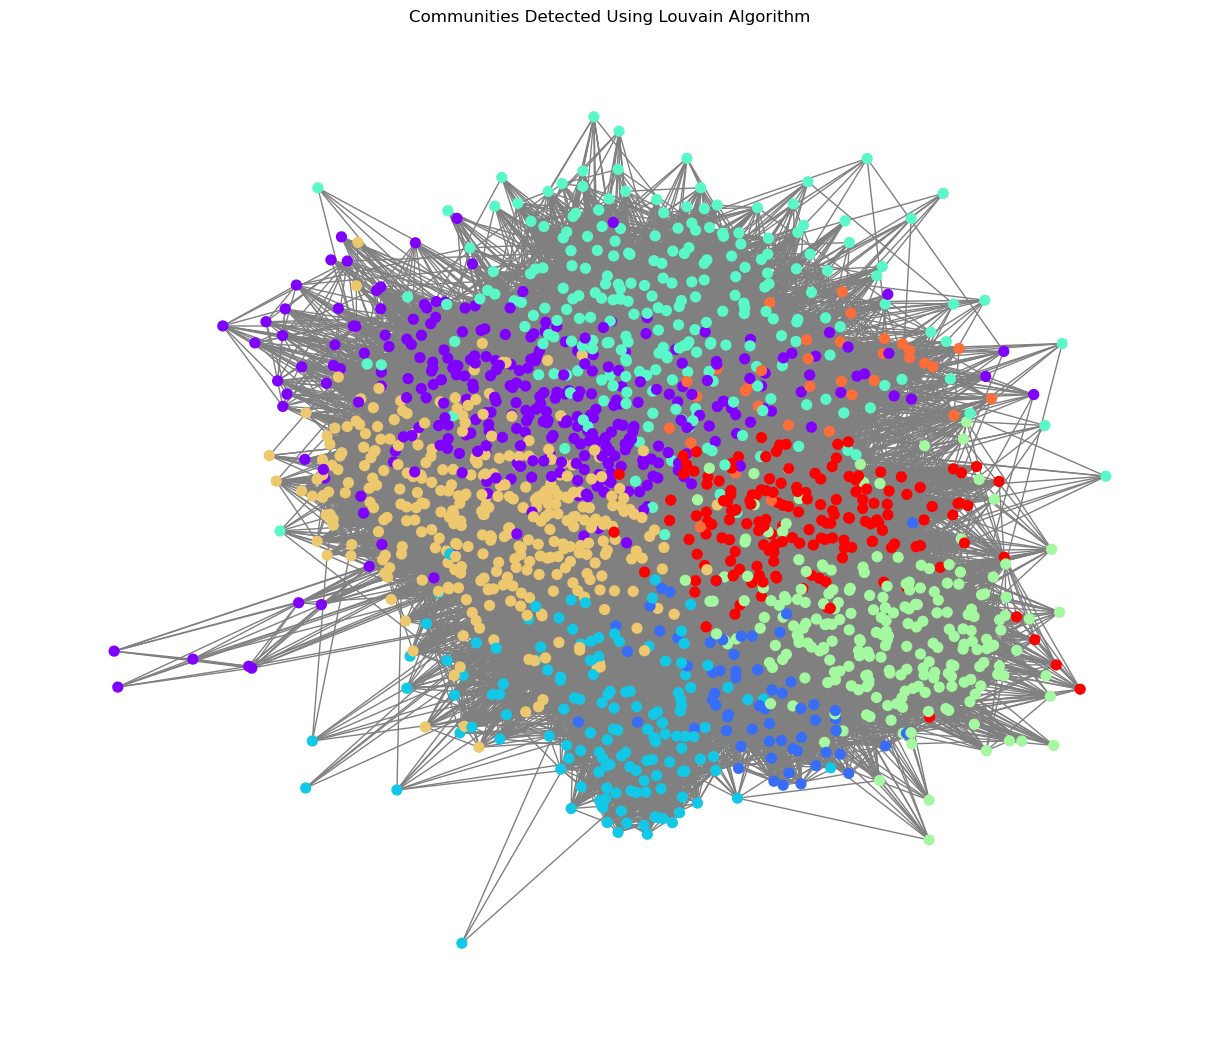

Number of internal edges in each community: [7058, 773, 2863, 4035, 5076, 9205, 354, 4444]
Top central nodes in Community 0: [('10671602', 0.30386378519973806), ('48485771', 0.28028814669286184), ('15222083', 0.24034053700065489), ('9451052', 0.22593320235756387), ('15234657', 0.21938441388343158)]
Top central nodes in Community 1: [('145809544', 0.06024885396201703), ('296242468', 0.0595939751146038), ('211614808', 0.05762933857236412), ('105895378', 0.056319580877537655), ('351092905', 0.056319580877537655)]
Top central nodes in Community 2: [('18776017', 0.31761624099541585), ('116952434', 0.22396856581532418), ('36198161', 0.17354289456450558), ('184637153', 0.12704649639816634), ('22705686', 0.12639161755075312)]
Top central nodes in Community 3: [('3359851', 1.0), ('7861312', 0.17943680419122462), ('115485051', 0.14800261951538965), ('31353077', 0.13817943680419123), ('10350', 0.1283562540929928)]
Top central nodes in Community 4: [('34068984', 0.3051735428945645), ('22784458', 0

In [15]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
import matplotlib.pyplot as plt

# Step 2: Run the Louvain Community Detection Algorithm
# Parameters: weight='weight', resolution=1, threshold=1e-07, max_level=None
communities = louvain_communities(subset_G, resolution=1, threshold=1e-07, seed=42)

# Number of communities
print(f"Total number of communities: {len(communities)}")

# Size of each community
community_sizes = [len(community) for community in communities]
print("Sizes of communities:", community_sizes)


# Step 3: Visualize the Communities
def visualize_communities(graph, communities):
    # Assign colors to nodes based on their community
    community_map = {node: idx for idx, community in enumerate(communities) for node in community}
    node_colors = [community_map[node] for node in graph.nodes()]
    
    # Generate layout for better visualization
    pos = nx.spring_layout(graph)

    # Draw the graph
    plt.figure(figsize=(12, 10))
    nx.draw(
        graph, pos,
        node_color=node_colors,
        with_labels=False,
        cmap=plt.cm.rainbow,
        node_size=50,
        edge_color="gray"
    )
    plt.title("Communities Detected Using Louvain Algorithm")
    
    # Save the plot
    plt.savefig("louvain_communities.png", format="png", dpi=300)  # Save as PNG with high resolution
    plt.show()

# Call visualization
visualize_communities(subset_G, communities)


internal_edges = [subset_G.subgraph(community).number_of_edges() for community in communities]
print("Number of internal edges in each community:", internal_edges)

degree_centrality = nx.degree_centrality(subset_G)
for idx, community in enumerate(communities):
    centrality = {node: degree_centrality[node] for node in community}
    sorted_centrality = sorted(centrality.items(), key=lambda item: item[1], reverse=True)
    print(f"Top central nodes in Community {idx}:", sorted_centrality[:5])

for idx, community in enumerate(communities):
    print(f"Community {idx}:")
    print(f"Size: {len(community)}")
    print(f"Internal Edges: {internal_edges[idx]}")
    print(f"Top central nodes: {sorted_centrality[:5]}")


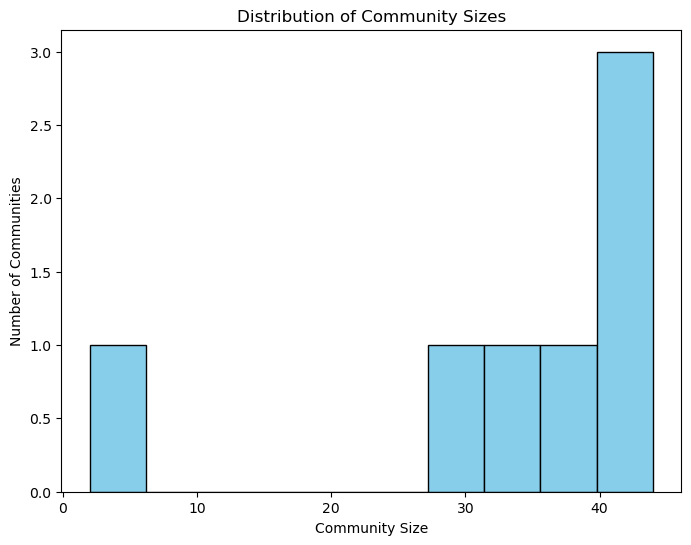

In [62]:
import matplotlib.pyplot as plt

# Plot community size distribution
plt.figure(figsize=(8, 6))
plt.hist(community_sizes, bins=10, color="skyblue", edgecolor="black")
plt.xlabel("Community Size")
plt.ylabel("Number of Communities")
plt.title("Distribution of Community Sizes")
plt.show()


In [64]:
# Compute centrality measures
degree_centrality = nx.degree_centrality(subset_G)

# Identify top nodes in each community
for idx, community in enumerate(communities):
    top_node = max(community, key=lambda node: degree_centrality[node])
    print(f"Community {idx + 1}: Top node {top_node} (Degree Centrality: {degree_centrality[top_node]:.3f})")


Community 1: Top node 849131 (Degree Centrality: 0.304)
Community 2: Top node 627363 (Degree Centrality: 0.270)
Community 3: Top node 11336782 (Degree Centrality: 0.361)
Community 4: Top node 793219 (Degree Centrality: 0.222)
Community 5: Top node 182013328 (Degree Centrality: 0.004)
Community 6: Top node 27478849 (Degree Centrality: 0.187)
Community 7: Top node 50393960 (Degree Centrality: 0.413)


In [66]:
# Intra-community edges
def intra_community_edges(graph, community):
    return graph.subgraph(community).number_of_edges()

# Inter-community edges
def inter_community_edges(graph, community1, community2):
    return len([
        (u, v) for u in community1 for v in community2 if graph.has_edge(u, v)
    ])

# Compute edge metrics
for idx, community in enumerate(communities):
    intra_edges = intra_community_edges(subset_G, community)
    print(f"Community {idx + 1}: {len(community)} nodes, {intra_edges} intra-community edges")


Community 1: 32 nodes, 223 intra-community edges
Community 2: 39 nodes, 205 intra-community edges
Community 3: 41 nodes, 216 intra-community edges
Community 4: 44 nodes, 142 intra-community edges
Community 5: 2 nodes, 1 intra-community edges
Community 6: 29 nodes, 95 intra-community edges
Community 7: 44 nodes, 141 intra-community edges


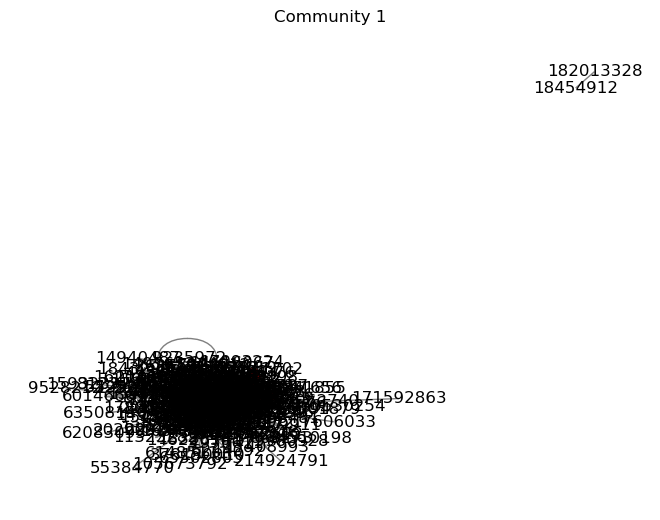

In [68]:
def visualize_single_community(graph, community, title):
    pos = nx.spring_layout(graph)
    nx.draw(
        graph, pos,
        nodelist=community,
        node_color="red",
        with_labels=True,
        node_size=50,
        edge_color="gray"
    )
    plt.title(title)
    plt.show()

# Visualize a specific community
visualize_single_community(subset_G, communities[0], "Community 1")


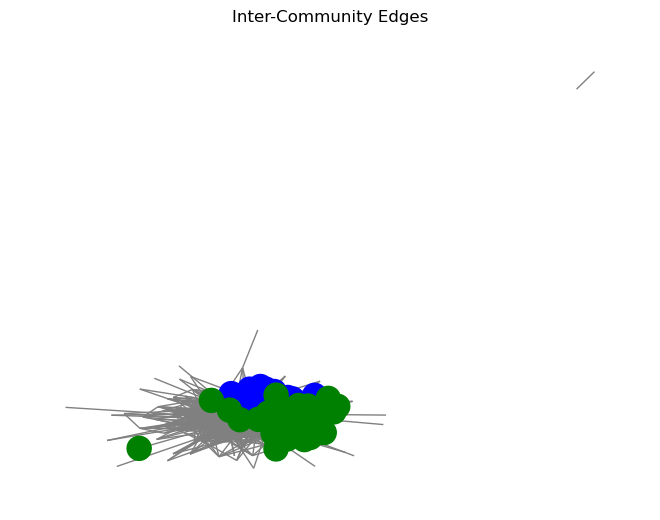

In [70]:
def visualize_inter_community_edges(graph, comm1, comm2):
    pos = nx.spring_layout(graph)
    nx.draw(
        graph, pos,
        nodelist=list(comm1) + list(comm2),
        node_color=["blue"] * len(comm1) + ["green"] * len(comm2),
        with_labels=False,
        edge_color="gray"
    )
    nx.draw_networkx_edges(
        graph, pos,
        edgelist=[(u, v) for u in comm1 for v in comm2 if graph.has_edge(u, v)],
        edge_color="red"
    )
    plt.title("Inter-Community Edges")
    plt.show()

# Visualize edges between Community 1 and Community 2
visualize_inter_community_edges(subset_G, communities[0], communities[1])


In [72]:
from networkx.algorithms.community.quality import modularity

# Compute modularity
modularity_score = modularity(subset_G, communities)
print(f"Modularity of the partition: {modularity_score:.3f}")

for idx, community in enumerate(communities):
    subgraph = subset_G.subgraph(community)
    density = nx.density(subgraph)
    print(f"Community {idx + 1}: Density = {density:.3f}")


Modularity of the partition: 0.275
Community 1: Density = 0.450
Community 2: Density = 0.277
Community 3: Density = 0.263
Community 4: Density = 0.150
Community 5: Density = 1.000
Community 6: Density = 0.234
Community 7: Density = 0.149


Big clam implementation

In [30]:
import numpy as np
import networkx as nx

# Subset graph is already created as `subset_G`
nodes = np.array(list(subset_G.nodes()))
edges = list(subset_G.edges())

# Function to compute connections and non-connections
def get_connections(edges, nodes):
    NN = len(nodes)
    conns = {}
    for i, j in edges:
        conns.setdefault(i, []).append(j)
        conns.setdefault(j, []).append(i)
    all_nodes = set(nodes)
    nconns = {i: list(all_nodes - set(conns.get(i, [])) - {i}) for i in nodes}
    return conns, nconns

# Compute connections and non-connections
conns, nconns = get_connections(edges, nodes)
print("Connections:", conns)
print("Non-Connections:", nconns)
k = 2  # Number of communities
np.random.seed(42)
F = np.random.random((len(nodes), k)) * 0.1  # Random positive values
print("Initial F matrix:\n", np.around(F, 3))

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

